In [1]:
#First we clarify the problem we want to solve this time
#We presume, we are holding a campaign in an e-commerce site
#We have two pages for one same step, the old one (control/null) and the new one (treatment/alternative)
#We are trying to find out, if the new page leads to a significant improvement on Conversion, comparing to the old page

In [2]:
#We are going to use A/B test, a common method to solve problem like this
#But there are several different types of A/B test
#Based on which kind of Distribution that our data follows, we have to choose different type of A/B test

In [3]:
#The problem in this case is about the Conversion Rate of the page
#When people click the page it is a "YES/ONE", otherwise it is a "NO/ZERO"
#It follows NOT a Gaussian Distribution (e.g. Normal Distribution), but a Bernoulli Distribution
#So we are going to use the Chi-Square type of A/B test this time

In [4]:
#We follow these three steps below when conducting Chi-Square A/B test 
#Step 1. Calculate the Chi-Squared test statistic
#Step 2. Calculate the p-value
#Step 3. Compare the p-value against the level of significance

In [28]:
#The introduction is as above, let us begin now
#First we import the libraries and our dataset

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

df = pd.read_csv(r'D:\kaggle\input\ab-test-chi-square-conversion\ab_data.csv')

In [29]:
#Data Cleansing we do, before performing A/B test
#Let check if there are any users in the control group (A group) saw new page
#Or any users in the treatment group (B group) saw the old page

df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [30]:
#As we can see, some users in control group (A) saw new page and some in treatment group (B) saw old page
#It is not supposed to be like this, but I do not know how to reverse it
#We can simply remove these data here

df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [31]:
#Now the control group (A) is restricted to the old page, and the treatment group (B) is restricted to the new page
#Then we check the duplicate values in 'user_id'

df_cleaned['user_id'].duplicated().sum()

1

In [32]:
#We want to dig more on this duplicated one

df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [33]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [34]:
#It seems that this user saw the new page twice and did not convert both time
#For the simplicity of the test, we want to restrict it to each user's first decision only
#Hence we remove the second instance for this user

df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep='first')

<AxesSubplot:xlabel='group,landing_page,converted'>

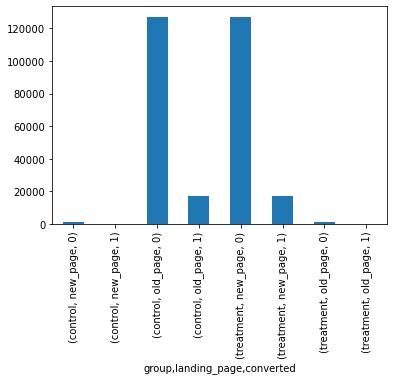

In [27]:
#The Data Cleansing part is over above, let us explore more on our data
#We plot the data against a Bar Chart, to see the proportions of Conversion on both groups

groups = df_cleaned.groupby(['group','landing_page','converted']).size()
groups.plot.bar()

<AxesSubplot:ylabel='landing_page'>

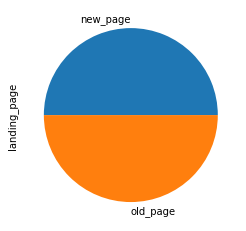

In [35]:
#It appears that they have similar Conversion Rate (approx. 1/7)
#We will see if there is a Significant difference through Chi-Square test

#As well, we use a Pie Chart to see if the proportions of numbers of users in each group is similar

df_cleaned['landing_page'].value_counts().plot.pie()

In [36]:
#Data Preparation we conduct here for the Chi-Square data

### Re-arrrange data into 2x2 for Chi-Squared

# 1) Split groups into two separate DataFrames
a = df_cleaned[df_cleaned['group'] == 'control']
b = df_cleaned[df_cleaned['group'] == 'treatment']
# 2) A-click, A-noclick, B-click, B-noclick
a_click = a.converted.sum()
a_noclick = a.converted.size - a.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()
# 3) Create np array
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [37]:
#Our data is in proper format, we conduct the Chi-Square test now
#We use the Spicy library, it will simply calculate the Chi-Square statistic and the p-value

import scipy
from scipy import stats
print(scipy.stats.chi2_contingency(T,correction=False)[1])

0.18988337448194853


In [38]:
#The p-value is calculated to be 19%
#Assuming 5% of Level of Significance, we deduce that p-value is greater than the alpha
#Hence we do NOT reject the null hypothesis
#In short term, there is no significance in conversions between old and new pages

In [39]:
#Sanity Check we conduct here

a_CTR = a_click / (a_click + a_noclick)
b_CTR = b_click / (b_click + b_noclick)
print(a_CTR, b_CTR)

0.1203863045004612 0.11880806551510564


In [40]:
#We now see that the Conversion Rates between the two groups and the difference between them is minimal
#This reassures us that this was conducted properly

In [41]:
#Our conclusion after the A/B test is that the new page does NOT leads to a significant improvement on the Conversion

In [ ]:
### A easy explanation of 'p-value' for people who barely knows statistics
#p-value is the probability under the null hypothesis of obtaining a result equals or more extreme than what we obseved
#We have 2 assumptions in A/B test, the null hypothesis and the alternative hypothesis
#Null hypothesis is no effect, no difference (new page leads no improvement)
#Alternative hypothesis is the opposite, statically we only has very small chance to obsever it (significance, usually 5%)
#If p-value < 5%, means something that is supposed to have an extremely small chance of happening, but happens
#So statistically, we have no more choice to explain it, but only to reject its assumption, the null hypothesis
#Vice versa